# Non-Negativ Matrix Factorization Model on 1-gram Tokens

In [1]:
import warnings
warnings.simplefilter('ignore')
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
from src.models.nmfTopicModeler import nmfTopicModeler

import pandas as pd
import numpy as np
import seaborn as sns

import pyLDAvis
import pyLDAvis.sklearn

### Load dataset

In [2]:
path_to_data = Path('../data')
df = pd.read_csv(path_to_data / 'processed' /'tokenized1gram_data.csv', converters={'tokenized': eval, 'tokenized_mults': eval, 'tokenized_mults_extr': eval})

### Fit model for cleaned token set (excl. extra stops)

In [3]:
topic_mdl = nmfTopicModeler(n_components = 8, max_iter = 10000)
topic_mdl.fit(df['tokenized_mults_extr'])

pyLDAvis.enable_notebook()
vis_nmf = pyLDAvis.sklearn.prepare(topic_mdl.mdl,\
                                   topic_mdl.doc_term_matrix, topic_mdl.vectors)
vis_nmf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.032571  0.099083       1        1  15.287240
2      0.045876  0.070496       2        1  14.199424
7      0.094575 -0.077144       3        1  13.668674
0      0.043915  0.012908       4        1  12.657535
6     -0.096280 -0.086007       5        1  11.955627
5      0.134845  0.168193       6        1  11.606024
4     -0.282578  0.018530       7        1  11.347647
1      0.092217 -0.206060       8        1   9.277830, topic_info=            Term       Freq      Total Category  logprob  loglift
654        csekk  47.000000  47.000000  Default  30.0000  30.0000
1877  hozzájárul  26.000000  26.000000  Default  29.0000  29.0000
2924       levél  37.000000  37.000000  Default  28.0000  28.0000
339         bank  21.000000  21.000000  Default  27.0000  27.0000
2150      jelszó  20.000000  20.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
5298      összeg   4.401948  32.520324   Topic8  -5.1741   0.3777
317    azonosító   3.205508  18.799102   Topic8  -5.4913   0.6086
4708        utal   3.454763  28.820346   Topic8  -5.4164   0.2562
47            ad   3.461285  32.749114   Topic8  -5.4145   0.1303
526    biztosító   2.809162  11.338450   Topic8  -5.6233   0.9822

[616 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
2         5  1.404891            157es
12        8  1.952378  2400dunaújváros
47        1  0.183211               ad
47        2  0.091606               ad
47        3  0.061070               ad
...     ...       ...              ...
5357      6  0.122215           ügyfél
5361      7  0.963261     ügyfélprofil
5362      2  0.323222  ügyfélszolgálat
5362      5  0.484832  ügyfélszolgálat
5369      7  1.030315           ügynök

[967 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 8, 1, 7, 6, 5, 2])

#### Show topic key words

In [4]:
topic_mdl.show_topics(8)

['tud szerződés név információ meghatalmazás ért telefon biztosítás',
 'bank csoportos megbízás levon von beszedési levonás terhelés',
 'díj évforduló éves biztosítás szerződés fizet következő negyedéves',
 'levél kap küld biztosítás email hátralék néz cím',
 'hozzájárul ajánlat adat elérhetőség akció megkeres szerződés álló',
 'csekk befizet fizet küld kap negyedév tud negyedéves',
 'jelszó tud cím email felület online felhasználónév regisztráció',
 'utal összeg közlemény lát számlaszám pénz utalás ír']

* 0 - adatvédelmi okokból csak a szerződőnek info 
* 1 - csoportos beszedés nem működött  
* 2 - évfordulóval kapcsolatos díjváltozást nem érti
* 3 - levél vagy email a hátralékról (inter, díjfelszólító)
* 4 - marketing hozzájárulás
* 5 - csekkes befizetés probléma
* 6 - online irányba terelés
* 7 - egyedi utalásos probléma

#### Show main topic distribution

In [4]:
# Drop administrative topics 
topic_mdl.drop_topics(drop_list = [0,4,6])

Dropped topics 0,4,6


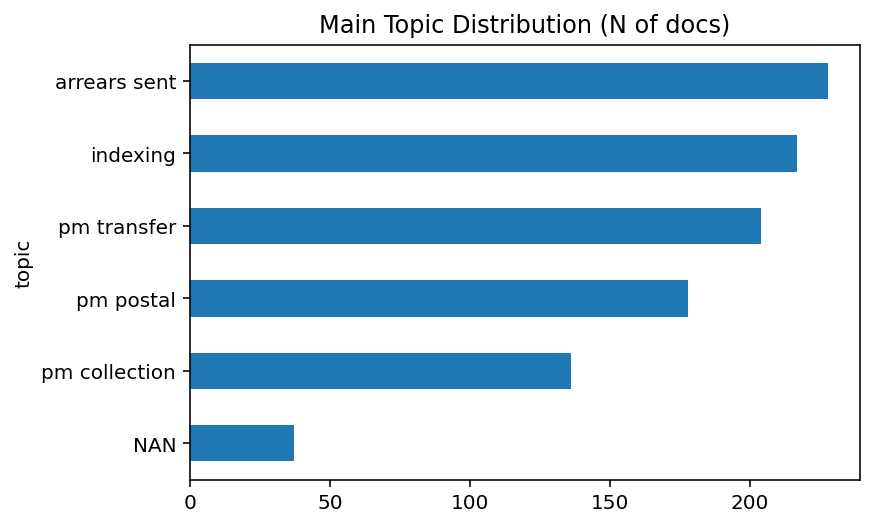

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

doc_main_topic, main_topic = topic_mdl.get_main_topic(topic_names = ['pm collection', 'indexing', 'arrears sent', 'pm postal', 'pm transfer', 'NAN'],\
                                    threshold = 0.015)
main_topic['count'][::-1].plot.barh(title = 'Main Topic Distribution (N of docs)');

#### Show topic frequency

In [6]:
topic_mdl.get_topic_frequency(topic_names =\
['pm collection', 'annual', 'arrears sent', 'pm postal', 'pm direct'],\
                              threshold = 0.015)

,count,pct
arrears sent,518,0.257840
annual,486,0.241911
pm direct,414,0.206073
pm postal,355,0.176705
pm collection,236,0.117471


#### Show multi-topic distribution

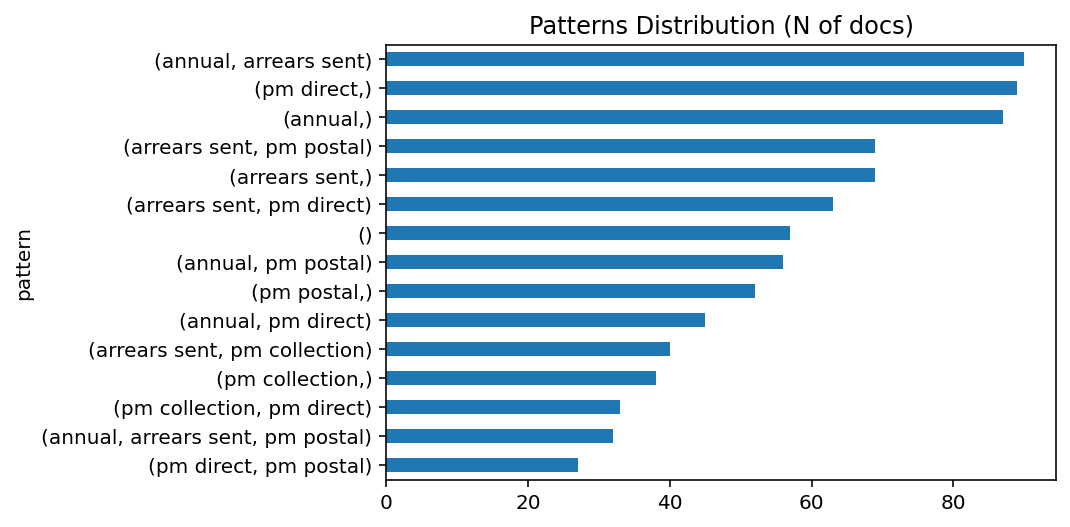

In [6]:
doc_pattern, topic_patterns = topic_mdl.get_topic_patterns(topic_names = ['pm collection', 'annual', 'arrears sent', 'pm postal', 'pm direct'],\
                                    threshold = 0.02)

topic_patterns = topic_patterns.iloc[0:15, 0][::-1]
topic_patterns.plot.barh(title = 'Patterns Distribution (N of docs)');

In [9]:
df_pattern = df.join(pattern_by_doc)
df_pattern.loc[:, ['file_name', 'text', 'pattern']].to_csv(path_to_data / 'processed' / '1gram_pattern_inspect.csv')

NameError: name 'pattern_by_doc' is not defined

### Fit model for main topic and first N of tokens

In [7]:
doc_sub_patterns, sub_patterns = topic_mdl.fit_submodels(df['tokenized_mults_extr'], doc_pattern, topn_topics=2, n_subtokens=20,\
                     n_subtopics=5, n_subwords=8, threshold = 0.02)
# doc_sub_mains, sub_mains = topic_mdl.fit_submodels(df['tokenized_mults_extr'], doc_main_topic, n_subtokens=20,\
#                      n_subtopics=5, n_subwords=8, threshold = 0.02)

Int64Index([  5,  21,  22,  36,  49,  54,  67,  70,  72,  85,  89,  90,  93,
             95, 108, 124, 130, 135, 144, 178, 184, 235, 242, 249, 267, 275,
            277, 284, 296, 299, 302, 306, 315, 320, 321, 330, 341, 351, 434,
            475, 509, 510, 516, 523, 525, 533, 551, 564, 575, 585, 597, 606,
            609, 615, 617, 621, 639, 644, 657, 683, 695, 704, 707, 708, 723,
            730, 756, 774, 790, 810, 816, 848, 859, 866, 868, 873, 878, 882,
            896, 897, 901, 920, 931, 944, 945, 952, 968, 977, 983],
           dtype='int64')
RangeIndex(start=0, stop=89, step=1)
Int64Index([ 16,  20,  24,  30,  48,  69,  82,  92,  97, 115, 118, 121, 139,
            157, 167, 174, 176, 188, 194, 207, 211, 218, 222, 229, 232, 236,
            243, 260, 261, 270, 272, 273, 276, 292, 300, 317, 319, 340, 371,
            375, 415, 419, 441, 448, 471, 472, 479, 530, 534, 554, 562, 572,
            586, 588, 591, 595, 608, 626, 628, 632, 646, 651, 655, 656, 701,
            713, 731, 

In [11]:
#sub_mains = sub_mains.reset_index().rename(columns={'level_0': 'main_topic', 'topic': 'sub_topic'})

In [15]:
sub_mains

count  \
              topic                                                       
indexing      lakcím születési ad azonosítás dátum állandó sz...     54   
              biztosítás autó kötelező gépjármű casco kap nap...     52   
              tud szerződés segít szám azonosító ad ügyfél la...     48   
              díj éves kap csekk fizetés kérdés következő bef...     46   
              biztosító munkatárs beszél magyarország rögzít ...     17   
NAN           biztosítás név szám fizet próbál anya maradva k...      9   
              lakcím ad születési azonosítás állandó segít eg...      8   
              tud segít azonosító ad elmaradás jön szerződés ...      8   
              szerződés segítség online nap email tud köt törlés      7   
              beszél biztosító ígér visszahívás hív alkalmas ...      5   
pm transfer   biztosítás kap tud kötelező nap gépjármű küld megy     58   
              születési ad lakcím azonosítás dátum nap álland...     43   
              szerződés ügyfél szám segítség lát néz kapcsola...     41   
              fizet köt tud pénz nap díj megkap befizetés            35   
              utal összeg probléma néz díj utalás lakásbiztos...     27   
pm postal     csekk kap küld tud biztosítás nap első biztosító       53   
              lakcím születési dátum ad azonosítás elérhetősé...     39   
              fizet díj lakásbiztosítás lát csekken negyedéve...     29   
              tud szerződés segít szám ad azonosító néz elmar...     29   
              befizet gépjármű jön biztosítás felelősségbizto...     28   
pm collection biztosítás von köt gépjármű nap számla ír lakás        35   
              csoportos beszedés első éves halló megbízás tud...     33   
              szerződés szám tud segít ad azonosító nap ügyfél       30   
              lakcím születési ad egyeztet elérhetőség azonos...     20   
              fizet kap átutalás bank levél email befizet lak...     18   
arrears sent  kap tud fizet nap lakásbiztosítás értesítés néz...     79   
              ad lakcím születési azonosítás szerződés dátum ...     53   
              biztosítás autó köt nap kis megkérdez kap vesz         48   
              kötelező gépjármű felelősségbiztosítás díj hátr...     38   
              alkalmas időpont biztosító magyarország tájékoz...     10   

                                                                       pct  \
              topic                                                          
indexing      lakcím születési ad azonosítás dátum állandó sz...  0.248848   
              biztosítás autó kötelező gépjármű casco kap nap...  0.239631   
              tud szerződés segít szám azonosító ad ügyfél la...  0.221198   
              díj éves kap csekk fizetés kérdés következő bef...  0.211982   
              biztosító munkatárs beszél magyarország rögzít ...  0.078341   
NAN           biztosítás név szám fizet próbál anya maradva k...  0.243243   
              lakcím ad születési azonosítás állandó segít eg...  0.216216   
              tud segít azonosító ad elmaradás jön szerződés ...  0.216216   
              szerződés segítség online nap email tud köt törlés  0.189189   
              beszél biztosító ígér visszahívás hív alkalmas ...  0.135135   
pm transfer   biztosítás kap tud kötelező nap gépjármű küld megy  0.284314   
              születési ad lakcím azonosítás dátum nap álland...  0.210784   
              szerződés ügyfél szám segítség lát néz kapcsola...  0.200980   
              fizet köt tud pénz nap díj megkap befizetés         0.171569   
              utal összeg probléma néz díj utalás lakásbiztos...  0.132353   
pm postal     csekk kap küld tud biztosítás nap első biztosító    0.297753   
              lakcím születési dátum ad azonosítás elérhetősé...  0.219101   
              fizet díj lakásbiztosítás lát csekken negyedéve...  0.162921   
              tud szerződés segít szám ad azonosító néz elmar...  0.162921   
              befizet gépjá

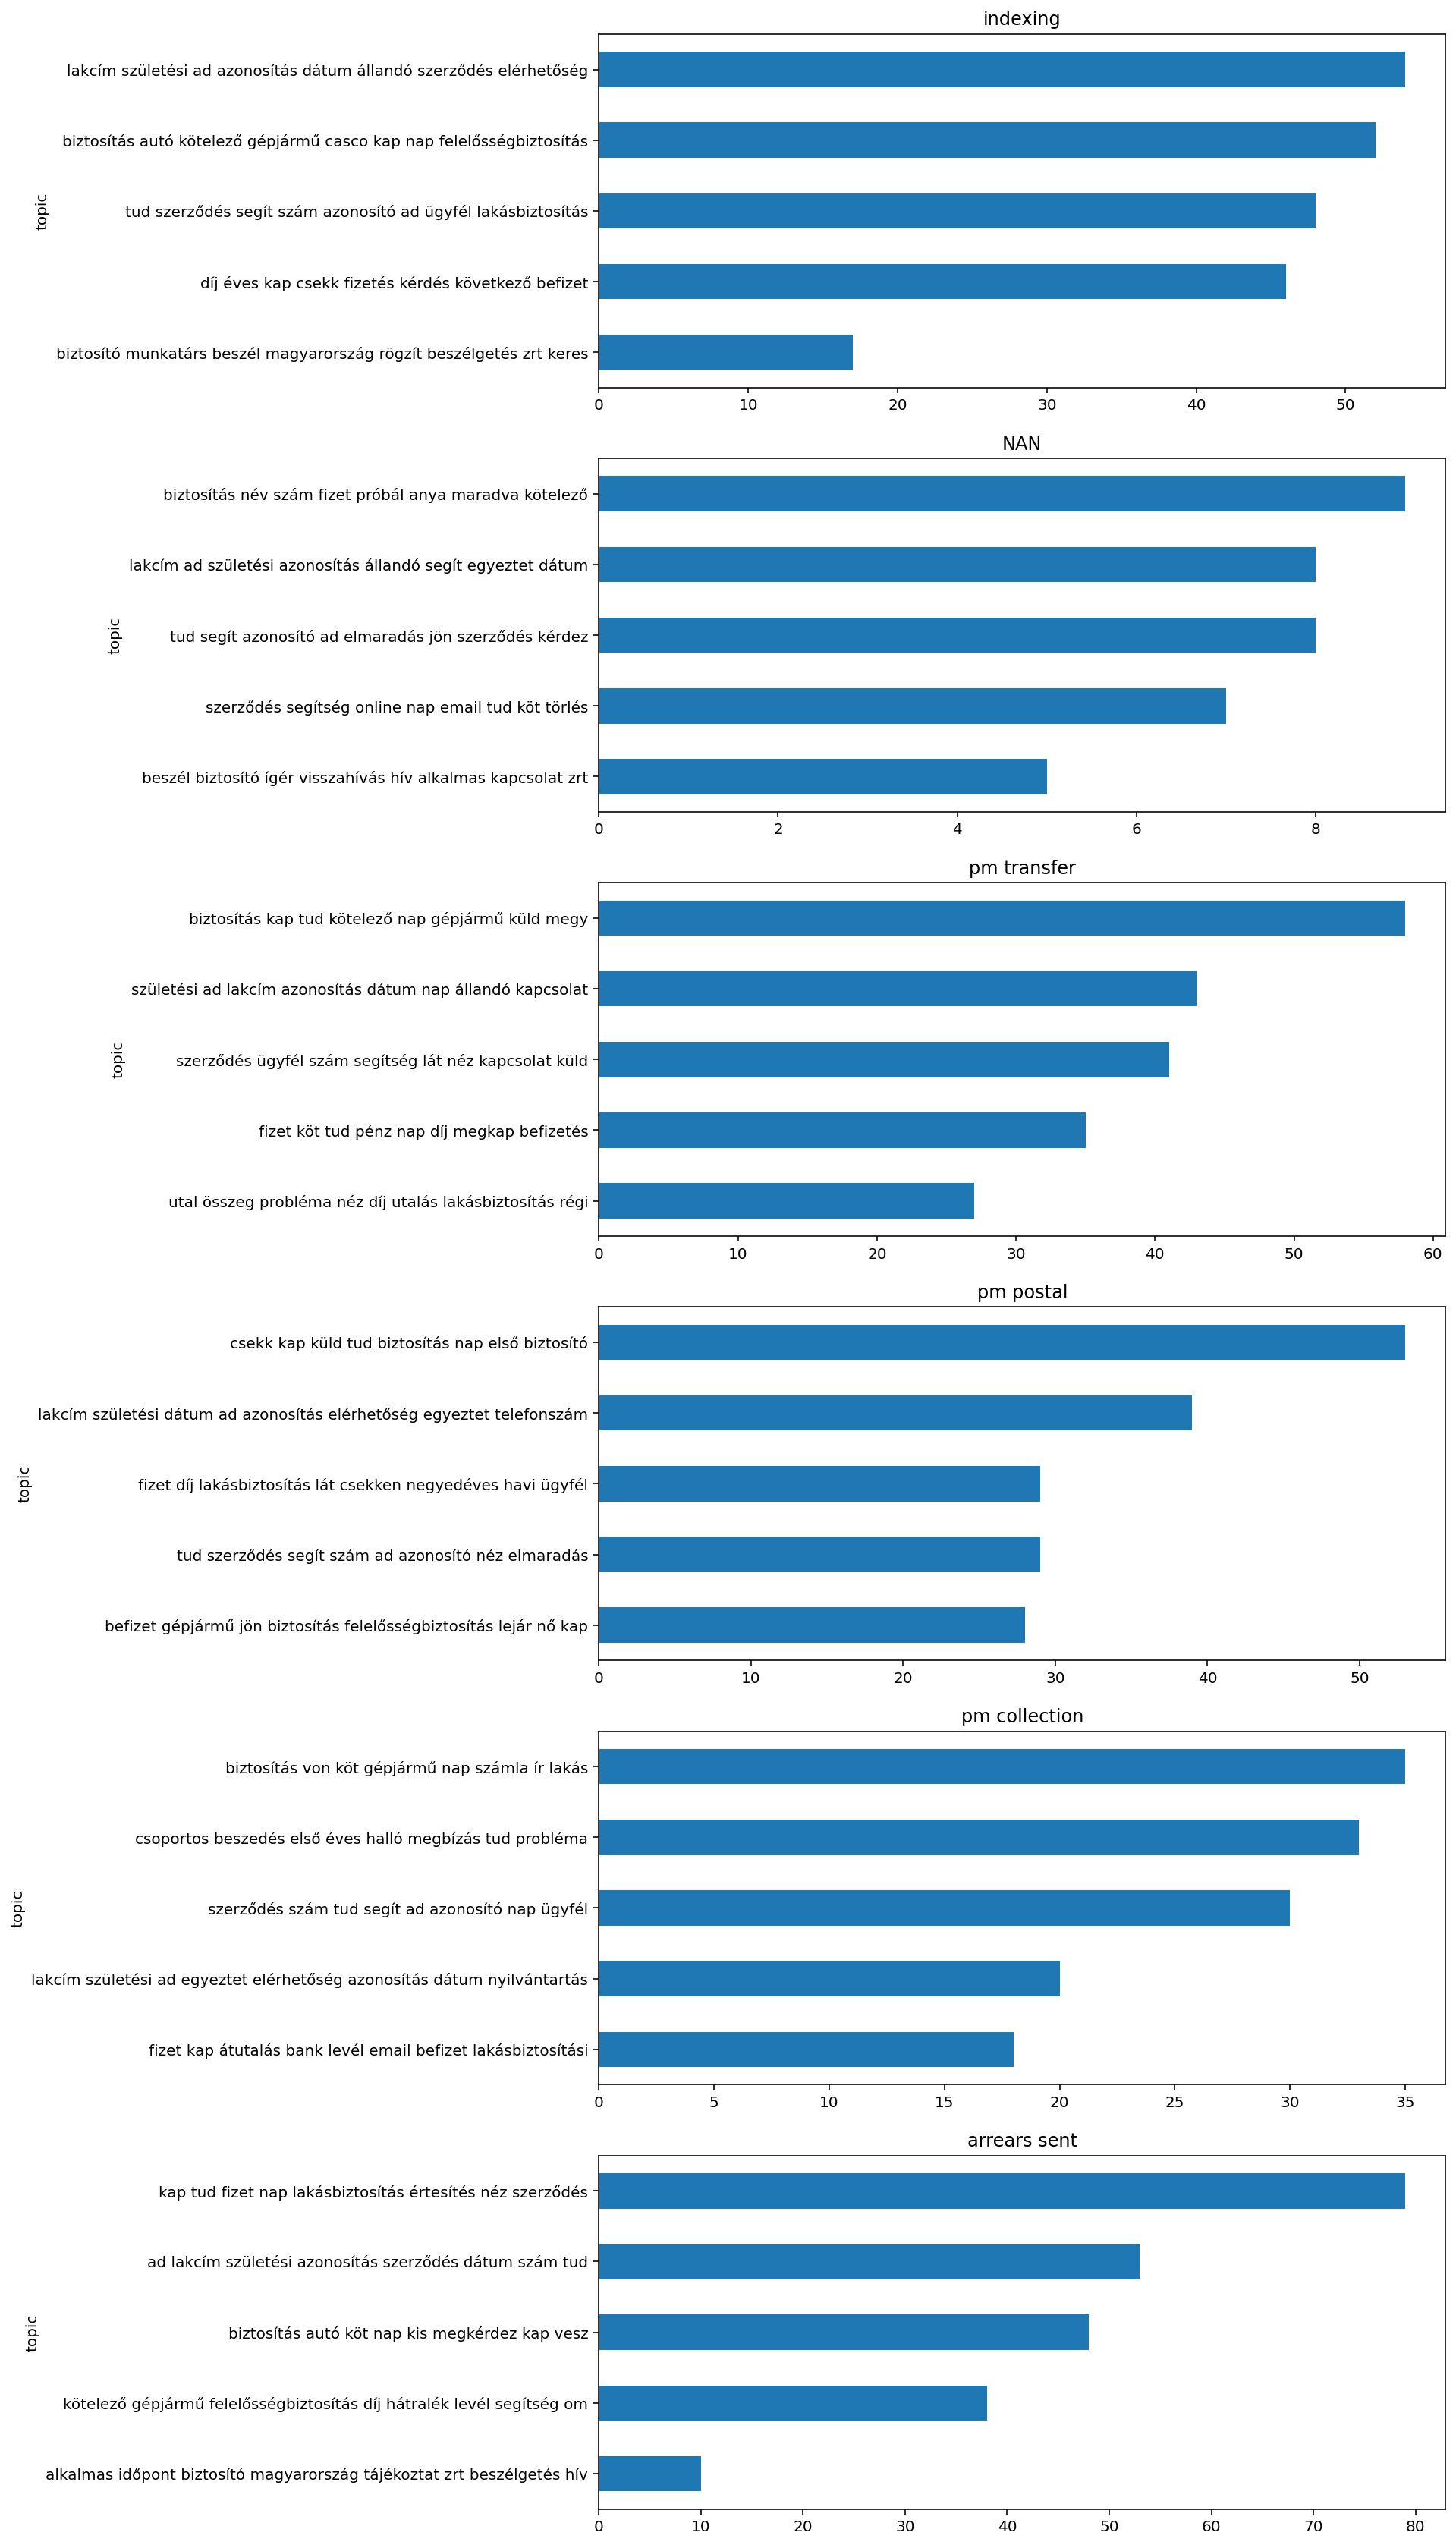

In [16]:
import matplotlib.pyplot as plt
f, a = plt.subplots(6, 1, figsize=(10, 30))
for idx, level in enumerate(sub_mains.index.levels[0]):
    sub_mains.loc[level, 'count'][::-1].plot(kind='barh', title = level, ax=a[idx])

In [47]:
sub_patterns.reset_index().rename(columns={'level_0': 'pattern', 'topic': 'sub_topic'})

,pattern,sub_topic,count,pct,pct roll
0,"('annual',)",ad lakcím születési azonosítás elérhetőség egy...,22,0.252874,0.252874
1,"('annual',)",díj éves kérdés fizetés kapcsolat nap szerződé...,20,0.229885,0.482759
2,"('annual',)",kötelező autó biztosítás casco fizet gépjármű ...,17,0.195402,0.678161
3,"('annual',)",tud segít szerződés szám ad azonosító rendszám...,17,0.195402,0.873563
4,"('annual',)",beszél biztosító munkatárs magyarország keres ...,11,0.126437,1.000000
5,"('pm direct',)",beszél díj megy probléma ügyfél kolléganő bizt...,27,0.303371,0.303371
6,"('pm direct',)",szerződés tud telefonál azonosító segít ügyfél...,22,0.247191,0.550562
7,"('pm direct',)",születési azonosítás lakcím nap ad dátum név á...,16,0.179775,0.730337
8,"('pm direct',)",fizet biztosítás tud nap hiba online technikai...,13,0.146067,0.876404
9,"('pm direct',)",néz pénz szerződés üzenet könyvelv utal szám küld,11,0.123596,1.000000


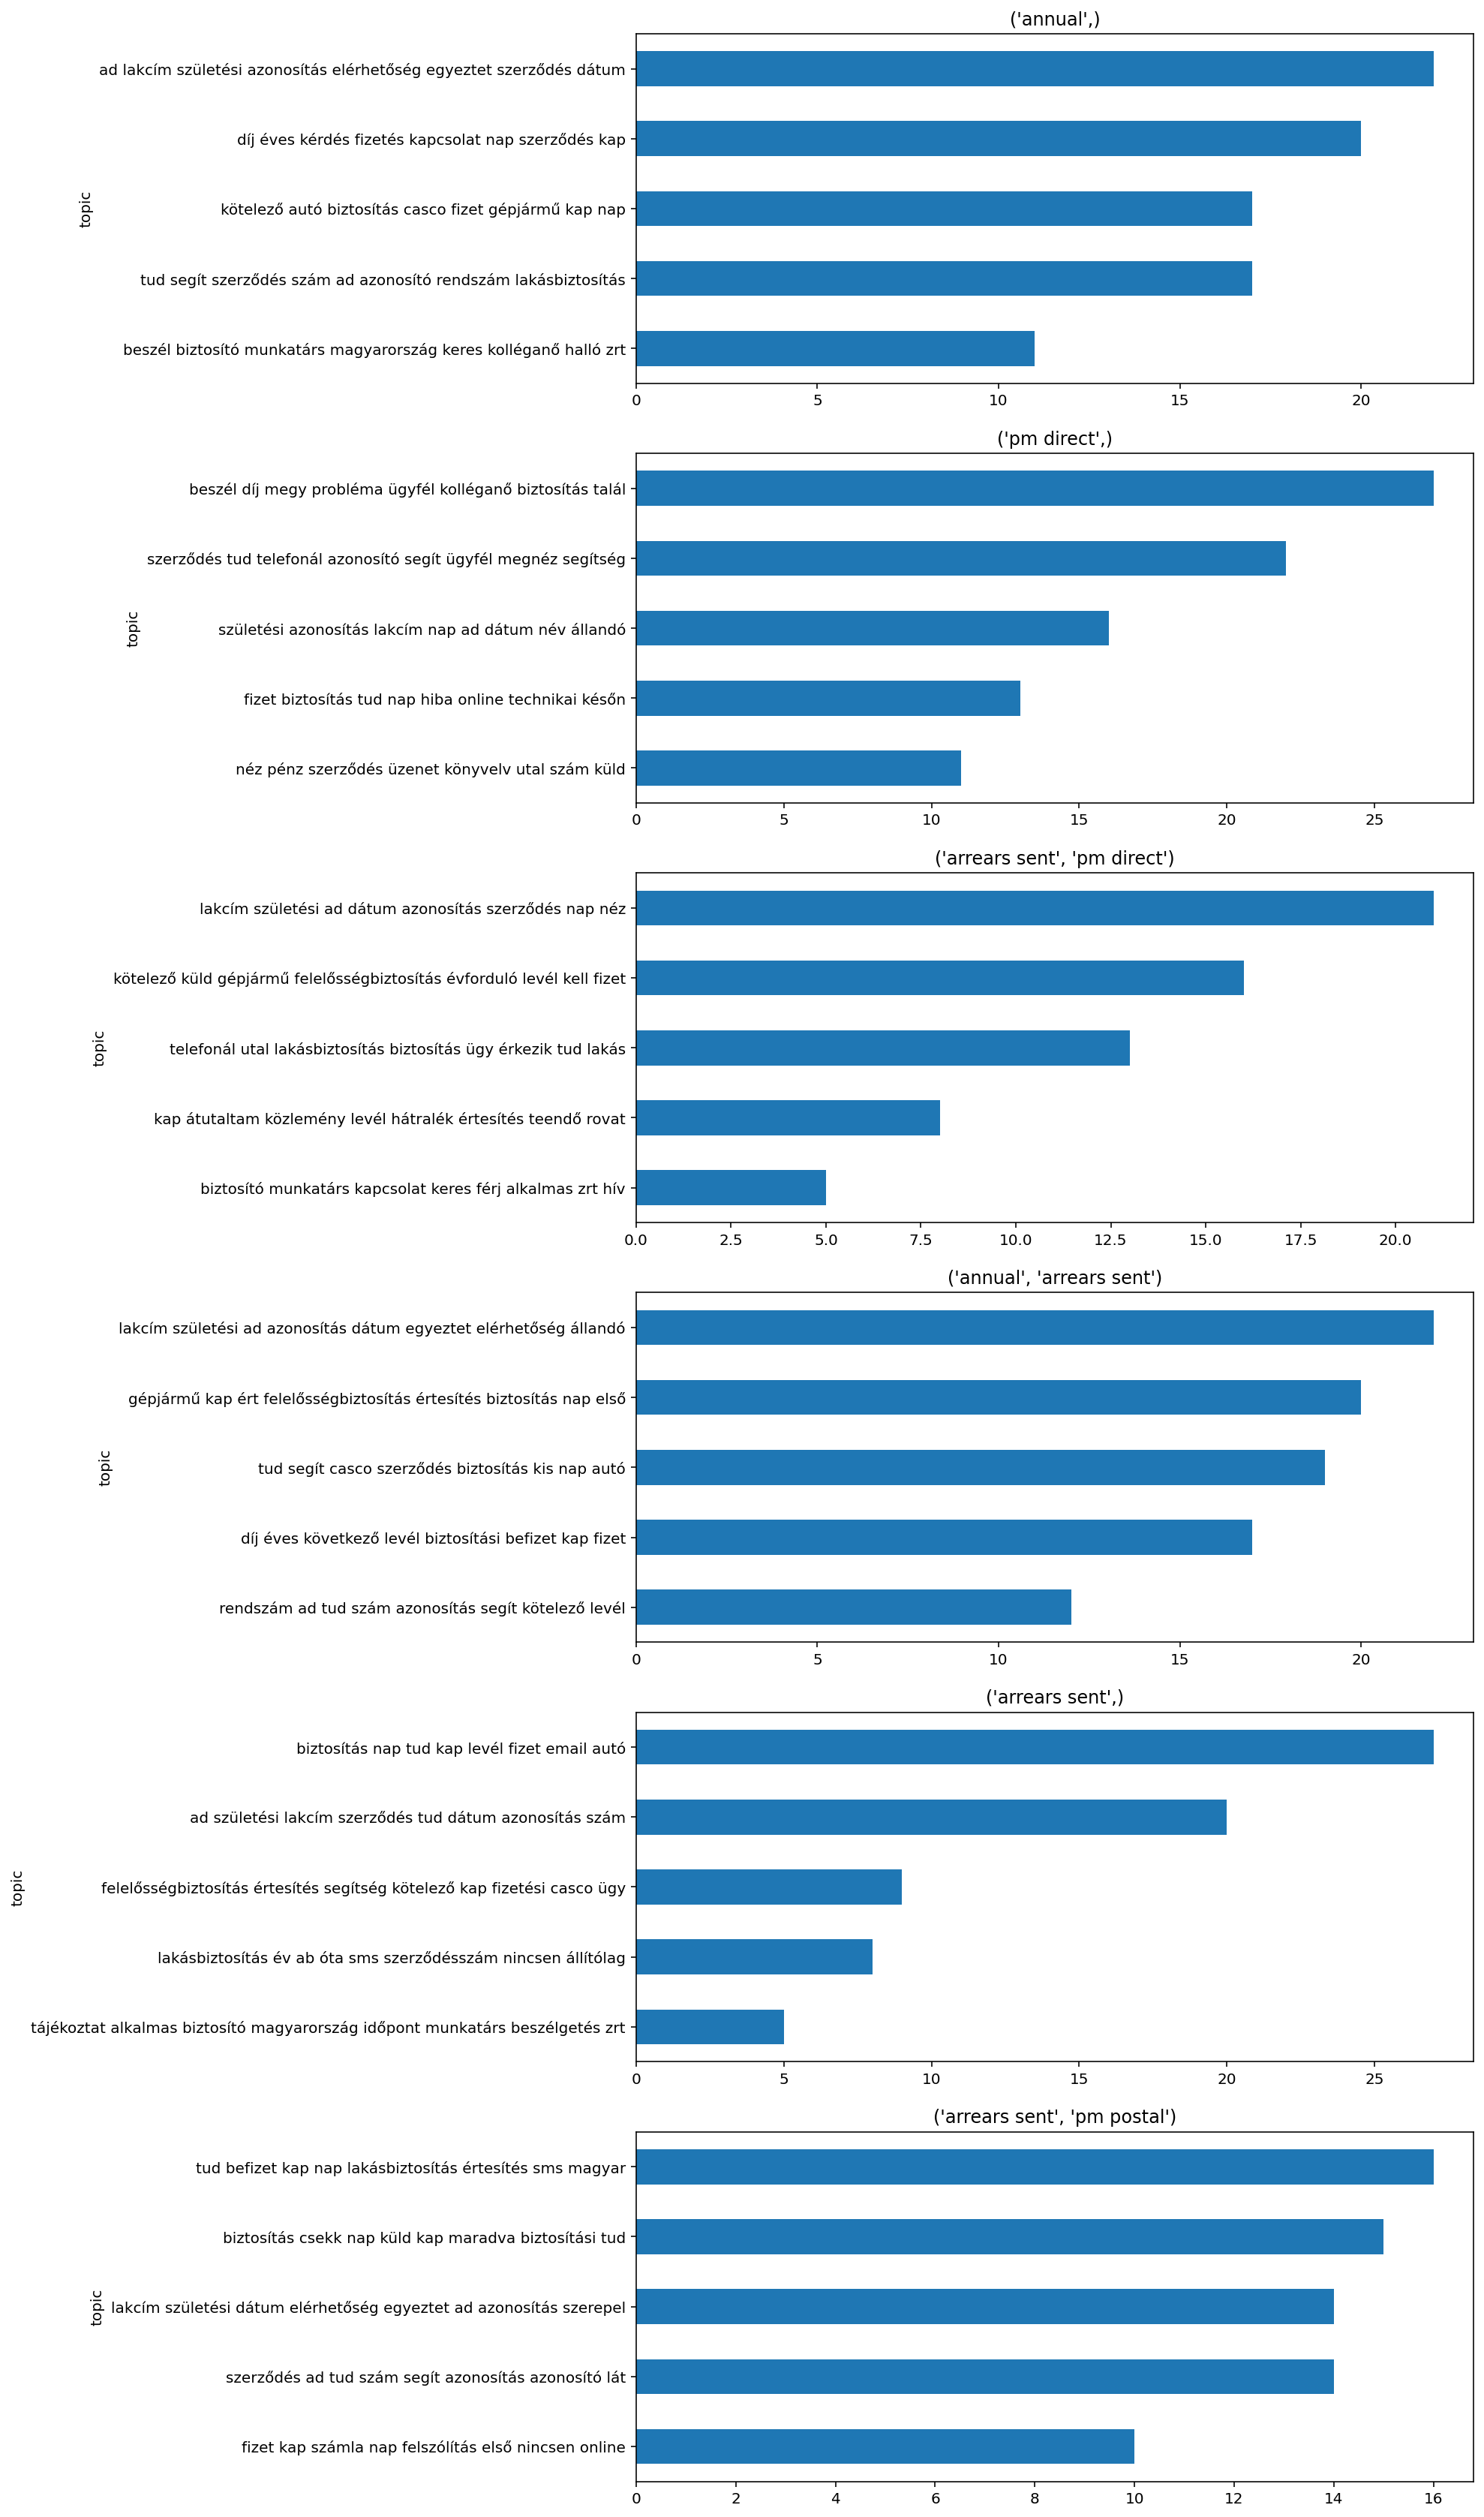

In [17]:
f, a = plt.subplots(6, 1, figsize=(10, 30))
for idx, level in enumerate(sub_patterns.index.levels[0]):
    sub_patterns.loc[level, 'count'][::-1].plot(kind='barh', title = level, ax=a[idx])

In [12]:
df.join(doc_sub_patterns)

,file_name,text,word_count,tokenized_raw,tokenized_raw_cnt,tokenized_mults,tokenized_mults_cnt,tokenized_mults_extr,tokenized_mults_extr_cnt,tokens,topic,tokens_sub
0,07211613C1,Üdvözlöm Ha rádióra vagyok miben segíthetek le...,275,"['üdvözlö', 'rádió', 'miben', 'segíthet', 'les...",143,"[üdvözlö, rádió, miben, segíthet, lesz, csókol...",133,"[rádió, helyzet, elcsúszik, kötelező, gépjármű...",97,"[rádió, helyzet, elcsúszik, kötelező, gépjármű...","(annual,)","[rádió, helyzet, elcsúszik, kötelező, gépjármű..."
1,07313221C2,Üdvözlöm miről Barbara vagyok miben segíthetek...,197,"['üdvözlö', 'mi', 'miben', 'segíthet', 'ön', '...",90,"[üdvözlö, mi, miben, segíthet, ön, nap, kíván,...",86,"[nap, probléma, lejár, úgymond, kötelező, éves...",60,NaN,NaN,NaN
2,07372317C1,esti Papp Ildikó biztosítótól és ki tudunk bes...,385,"['esti', 'biztosító', 'tud', 'beszél', 'igazáb...",171,"[esti, biztosító, tud, beszél, igazából, szüle...",164,"[esti, biztosító, tud, beszél, szüleim, lakás,...",127,NaN,NaN,NaN
3,07452941C2,Üdvözlöm Lőrincz Barbara vagyok miben segíthet...,448,"['üdvözlö', 'miben', 'segíthet', 'ön', 'nap', ...",216,"[üdvözlö, miben, segíthet, ön, nap, eszik, elő...",204,"[nap, eszik, beszél, ügyintéző, tud, jármű, bi...",155,NaN,NaN,NaN
4,07504737C1,Üdvözlöm Horváthné Papp Linda vagyok miben seg...,671,"['üdvözlöm', 'miben', 'segíthet', 'reggel', 'k...",299,"[üdvözlöm, miben, segíthet, reggel, kíván, seg...",288,"[reggel, segítség, szükség, gépjármű, biztosít...",219,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
995,17360670C2,Üdvözlöm Varga Nikoletta vagyok miben segíthet...,179,"['üdvözlö', 'miben', 'segíthet', 'nap', 'kíván...",92,"[üdvözlö, miben, segíthet, nap, kíván, onnan, ...",86,"[nap, nő, gépjármű, felelősségbiztosítás, on, ...",67,"[nap, nő, gépjármű, felelősségbiztosítás, on, ...","(annual, arrears sent)","[nap, nő, gépjármű, felelősségbiztosítás, on, ..."
996,17475591C1,Üdvözlöm Galgóczi virág vagyok miben segíthete...,545,"['üdvözlö', 'virág', 'miben', 'segíthet', 'ön'...",216,"[üdvözlö, virág, miben, segíthet, ön, üdvözlöm...",209,"[virág, szerződés, kapcsolat, egyeztet, rendsz...",157,NaN,NaN,NaN
997,181129118C2,Üdvözlöm Varga Nikoletta vagyok miben segíthet...,344,"['üdvözlö', 'miben', 'segíthet', 'ön', 'nap', ...",161,"[üdvözlö, miben, segíthet, ön, nap, kíván, oly...",155,"[nap, olyan, segítség, köt, gondoskodás, életb...",98,NaN,NaN,NaN
998,183428136C2,Üdvözlöm Varga Nikoletta vagyok miben segíthet...,433,"['üdvözlö', 'miben', 'segíthet', 'ön', 'kap', ...",238,"[üdvözlö, miben, segíthet, ön, kap, levél, eon...",234,"[kap, levél, eon, értesítés, azelőtt, esedékes...",191,"[kap, levél, eon, értesítés, azelőtt, esedékes...","(arrears sent,)","[kap, levél, eon, értesítés, azelőtt, esedékes..."


In [20]:
doc_sub_patterns.head(50)

topic
('annual',) 0   ad lakcím születési azonosítás elérhetőség egy...
            1   beszél biztosító munkatárs magyarország keres ...
            2   tud segít szerződés szám ad azonosító rendszám...
            3   tud segít szerződés szám ad azonosító rendszám...
            4   díj éves kérdés fizetés kapcsolat nap szerződé...
            5   tud segít szerződés szám ad azonosító rendszám...
            6   kötelező autó biztosítás casco fizet gépjármű ...
            7   ad lakcím születési azonosítás elérhetőség egy...
            8   díj éves kérdés fizetés kapcsolat nap szerződé...
            9   tud segít szerződés szám ad azonosító rendszám...
            10  tud segít szerződés szám ad azonosító rendszám...
            11  díj éves kérdés fizetés kapcsolat nap szerződé...
            12  ad lakcím születési azonosítás elérhetőség egy...
            13  ad lakcím születési azonosítás elérhetőség egy...
            14  beszél biztosító munkatárs magyarország keres ...
            15  tud segít szerződés szám ad azonosító rendszám...
            16  tud segít szerződés szám ad azonosító rendszám...
            17  beszél biztosító munkatárs magyarország keres ...
            18  tud segít szerződés szám ad azonosító rendszám...
            19  kötelező autó biztosítás casco fizet gépjármű ...
            20  tud segít szerződés szám ad azonosító rendszám...
            21  beszél biztosító munkatárs magyarország keres ...
            22  ad lakcím születési azonosítás elérhetőség egy...
            23  ad lakcím születési azonosítás elérhetőség egy...
            24  ad lakcím születési azonosítás elérhetőség egy...
            25  ad lakcím születési azonosítás elérhetőség egy...
            26  tud segít szerződés szám ad azonosító rendszám...
            27  kötelező autó biztosítás casco fizet gépjármű ...
            28  ad lakcím születési azonosítás elérhetőség egy...
            29  kötelező autó biztosítás casco fizet gépjármű ...
            30  kötelező autó biztosítás casco fizet gépjármű ...
            31  ad lakcím születési azonosítás elérhetőség egy...
            32  kötelező autó biztosítás casco fizet gépjármű ...
            33  beszél biztosító munkatárs magyarország keres ...
            34  tud segít szerződés szám ad azonosító rendszám...
            35  ad lakcím születési azonosítás elérhetőség egy...
            36  díj éves kérdés fizetés kapcsolat nap szerződé...
            37  ad lakcím születési azonosítás elérhetőség egy...
            38  díj éves kérdés fizetés kapcsolat nap szerződé...
            39  díj éves kérdés fizetés kapcsolat nap szerződé...
            40  kötelező autó biztosítás casco fizet gépjármű ...
            41  ad lakcím születési azonosítás elérhetőség egy...
            42  díj éves kérdés fizetés kapcsolat nap szerződé...
            43  tud segít szerződés szám ad azonosító rendszám...
            44  ad lakcím születési azonosítás elérhetőség egy...
            45  beszél biztosító munkatárs magyarország keres ...
            46  beszél biztosító munkatárs magyarország keres ...
            47  kötelező autó biztosítás casco fizet gépjármű ...
            48  kötelező autó biztosítás casco fizet gépjármű ...
            49  díj éves kérdés fizetés kapcsolat nap szerződé...